# Теоретические задачи 
## Задача 1
**Проведите тестирование методов хи-квадрат, Колмогорова, Крамера-Мизеса, Андерсона-Дарлинга проверки простой гипотезы для проверки нормальности 𝒩 (0, 1)**

для выборок размеров 25, 50, 100:

* в) из распределения Лапласа
* г) 𝒩(0,1),
* д) 𝒩 (0, 1) при значениях больших 1 по модулю и 𝑅[−1, 1] иначе
* e) с распределением Стьюдента с 5 степенями свободы.

Для тестирования сгенерируйте по 100 выборок для каждого распределения и подсчитайте для них фактические уровни значимости p-value. Постройте график для э.ф.р. p-value для каждого метода. Для правильного распределения эта э.ф.р. должна быть близка к равномерной ф.р., а для неправильного по возможности быть сильно выше. Какие критериии лучше справились?
## Задача 2

**Смоделировать выборки из 𝒩 ($\mu, \sigma^2$) и проверить их на нормальность с помощью**
* а) критерия Колмогорова-Смирнова с оцененными параметрами
* б) критерия Лиллефорса

## Задача 3

**Проверить нормальность выборки размеров 20, 50, 100 из**
* б) exp(1)
* г) хи-квадрат 1

**с помощью критериев Харке-Бера, Шапиро, Д’Агостино.**

# Практические задачи 

## Задача 1
Закон Бенфорда в его житейской интерпретации утверждает, что если выбрать набор каких-то чисел из реальных данных, то распределение первых цифр этих чисел будет иметь вид 
$𝑙𝑜𝑔_{10}(1+\frac{1}{k}), 𝑘 = 1, ..., 9$ 

Проверить его 
* а) на списке стран по населению, 
* б) на числах Фиббоначчи 
* в) интересном вам наборе данных.

## Задача 2
Kiama Blowhole - это австралийская достопримечательность, представляющая собой отверстие в скале, через которое через некоторые промежутки вылетают фонтаны воды (в русском языки та- кие объекты называют ”дыхалом”). 

В файле kiama.txt приведены промежутки (в секундах) между такими извержениями, зафиксированные за некоторый промежуток изучения. Можем ли мы утверждать, что извержения образуют пуассоновский процесс (то есть происходят через независимые экспоненциальные времена с одинаковым параметром). Если да, то оцените его параметр с помощью ОМП.


In [1]:
import pandas as pd
import numpy as np
import math
import sympy
from sympy import *
import scipy.stats as st

from scipy.stats import chisquare
from scipy.stats import kstest
from scipy.stats import cramervonmises
from scipy.stats import anderson

from matplotlib import pyplot as plt
import statsmodels.api as sm

from scipy.stats import laplace
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import t
from numpy.random import standard_t as student

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.filterwarnings("ignore")

# Т.1

Создание выборок

In [2]:
sizes = [25, 50, 100, 1000]
NORM = {25:[], 50:[], 100:[], 1000:[]}

ds = ['laplace', 'norm', 'norm_up', 'student']
N=100

selections = {'laplace':{25:[], 50:[], 100:[], 1000:[]}, 
              'norm':{25:[], 50:[], 100:[], 1000:[]},
              'norm_up':{25:[], 50:[], 100:[], 1000:[]}, 
              'student':{25:[], 50:[], 100:[], 1000:[]}}

 

for size in sizes:
    NORM[size] = np.random.normal(0, 1, size=size)
    for i in range(N): 
        points = []
        selections['laplace'][size].append(np.random.laplace(0, 1, size)) # laplace:
        selections['norm'][size].append(np.random.normal(0, 1, size=size)) # norm:
        selections['student'][size].append(student(100 , size))             # student 5
        
        for _ in range(size): # norm_up:
            point = norm.rvs(size=1)
            if abs(point[0]) < 1: 
                point = np.random.uniform(-1, 1, size=size)
                
            points.append(point[0])
            
        selections['norm_up'][size].append(points)

### 1) Критерий  $\chi^2$ 

In [3]:
def get_freq(points, y): 
    freq = []
    for i, item in enumerate(y): 
        if i == 0: 
            n = sum(points < item)
            
        elif i == y.shape[0] - 1:
            n = sum((y[i] > points) & (points >= y[i-1]))
            n1 = sum(points >= item)
            
        else: 
            n = sum((y[i] > points) & (points >= y[i-1]))
        
        freq.append(n)
        
    freq.append(n1)
        
    return freq 

In [4]:
def get_emp_freq(y, F, size): 
    freq = []
    for i, item in enumerate(y): 
        if i == 0: 
            p = F(item)
            
        elif i == y.shape[0] - 1:
            p = F(y[i]) - F(y[i-1])
            p1 = 1 - F(y[i])
            
        else: 
            p = F(y[i]) - F(y[i-1])
        
        freq.append(p * size)
        
    freq.append(p1 * size)
        
    return freq 

In [5]:
# Хи квадрат 
p_values = {'laplace': {25:[], 50:[], 100:[], 1000:[]},
              'norm':{25:[], 50:[], 100:[], 1000: []},
              'norm_up':{25:[], 50:[], 100:[], 1000: []}, 
              'student':{25:[], 50:[], 100:[], 1000:[]}}

F = norm.cdf

for distribution in ds: 
    for size in sizes:
        K = int(math.log2(size))
        y = np.linspace(1/K, 1 - 1/K, K-1)
        for i in range(N): 
            sample_obs = selections[distribution][size][i]
            f_obs = get_freq(sample_obs, y)
            f_exp = get_emp_freq(y, F, size)
            
            p_value = chisquare(f_obs, f_exp).pvalue
            
            p_values[distribution][size].append(p_value)


* $H_0$ : (нулевая гипотеза) Переменная следует за гипотетическим распределением ($p_{value}$ > $\alpha$)
* $H_1$ : (альтернативная гипотеза) Переменная не подчиняется предполагаемому распределению. ($p_{value}$ <= $\alpha$)


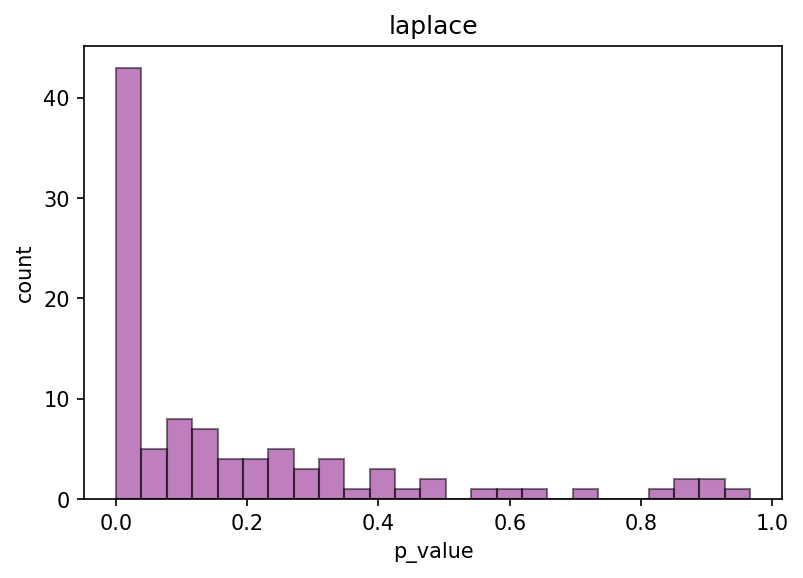

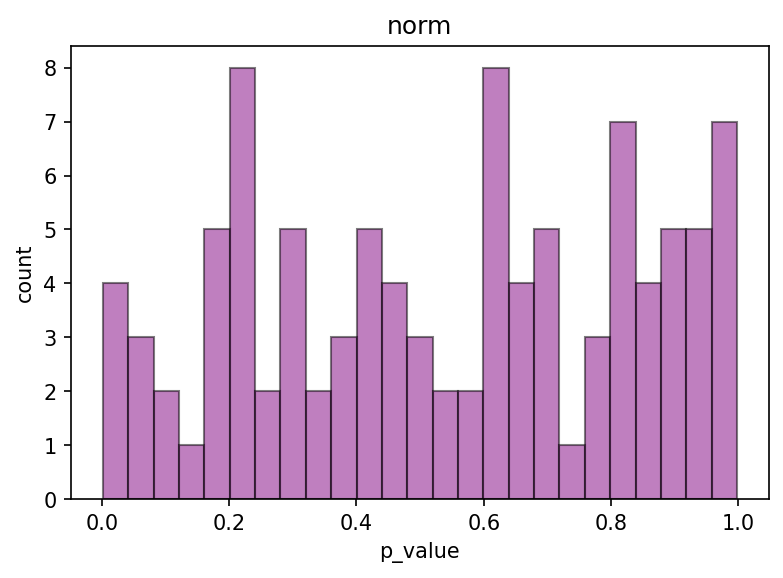

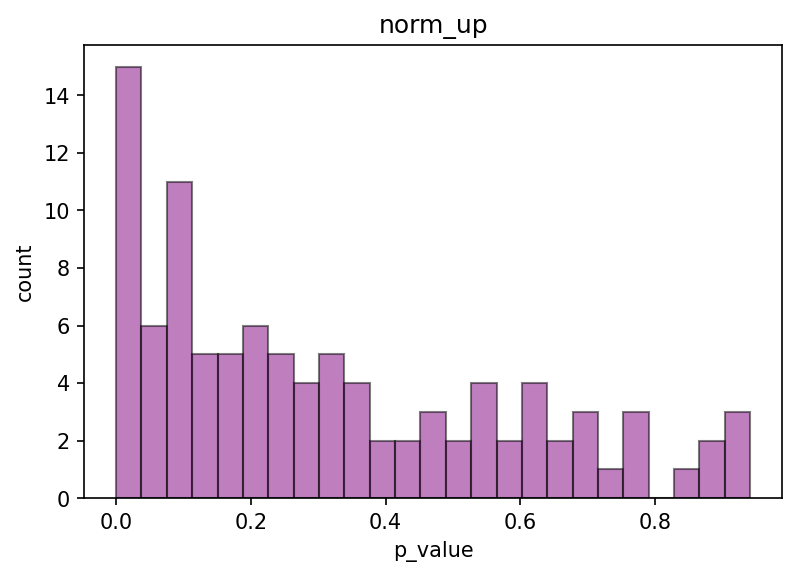

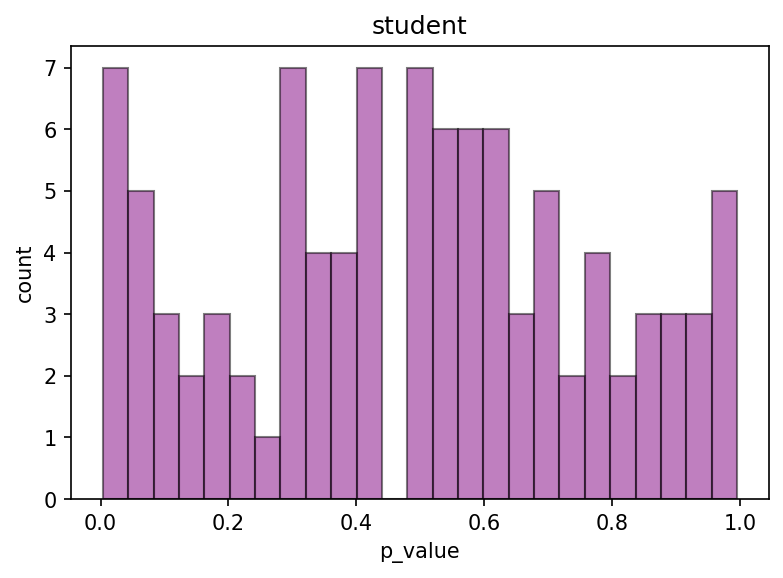

In [6]:
for distrib in ds: 
    plt.figure(dpi=150)
    plt.hist(p_values[distrib][1000], bins=25, alpha=0.5, color='purple', edgecolor='black',
         linestyle='-');
    plt.ylabel('count')
    plt.xlabel('p_value')
    plt.title(distrib)

### 2) Критерий  Колмогорова

In [7]:
def get_pvalues(F, test, selections): 
    p_values = {'laplace': {25:[], 50:[], 100:[], 1000:[]},
              'norm':{25:[], 50:[], 100:[], 1000: []},
              'norm_up':{25:[], 50:[], 100:[], 1000: []}, 
              'student':{25:[], 50:[], 100:[], 1000:[]}}

    for distribution in ds: 
        for size in sizes:
            for i in range(N): 
                sample_obs = selections[distribution][size][i]
                try: 
                    p_value = test(sample_obs, F, N=size).pvalue
                except: 
                    p_value = test(sample_obs, F).pvalue
                    
                p_values[distribution][size].append(p_value)
                
    return p_values

In [8]:
p_values = get_pvalues(norm.cdf, kstest, selections) 

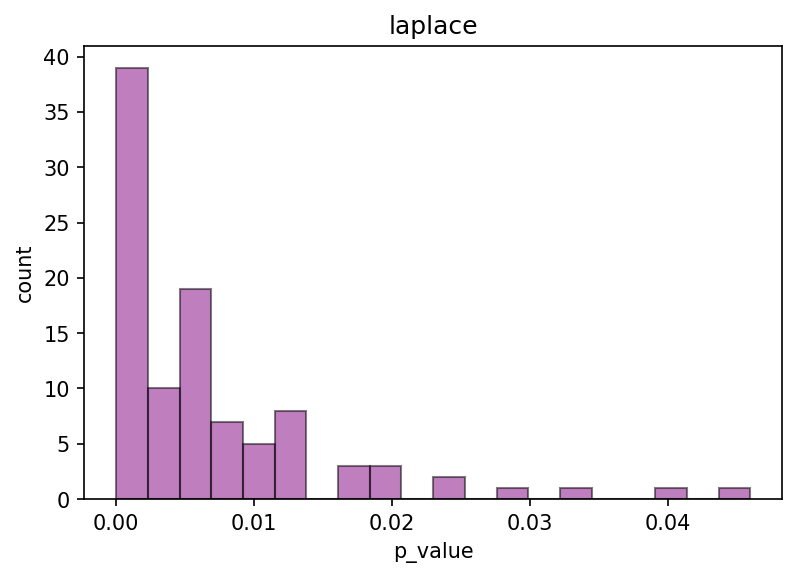

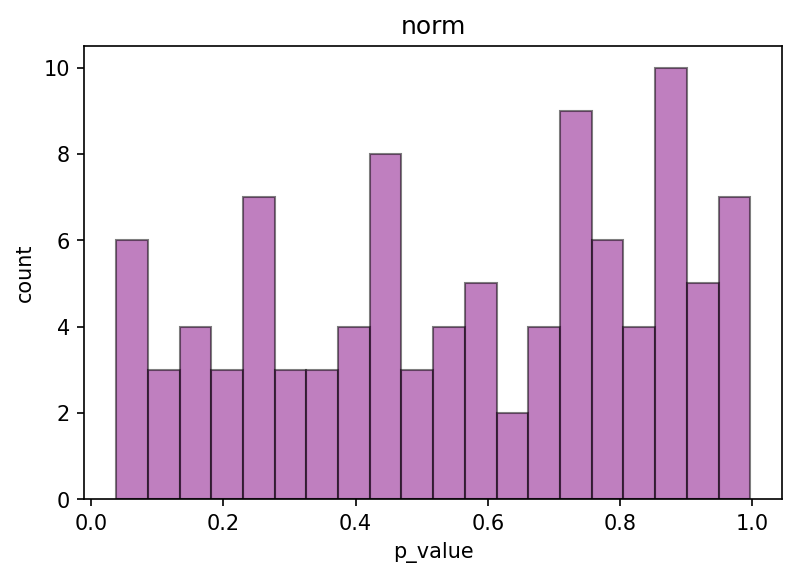

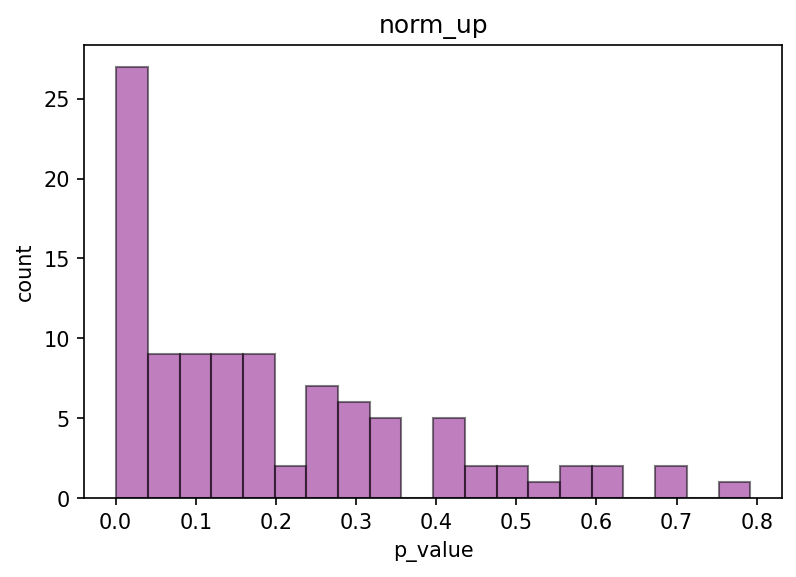

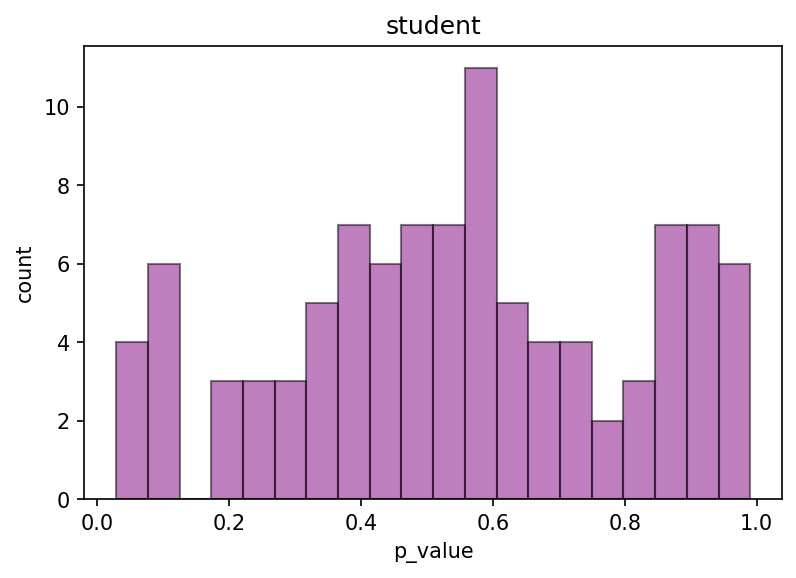

In [9]:
for distrib in ds: 
    plt.figure(dpi=150)
    plt.hist(p_values[distrib][1000], bins=20,alpha=0.5, color='purple', edgecolor='black',
         linestyle='-');
    plt.ylabel('count')
    plt.xlabel('p_value')
    plt.title(distrib)

### 3) Критерий  Крамера-Мизеса

In [10]:
p_values = get_pvalues(norm.cdf, cramervonmises, selections) 

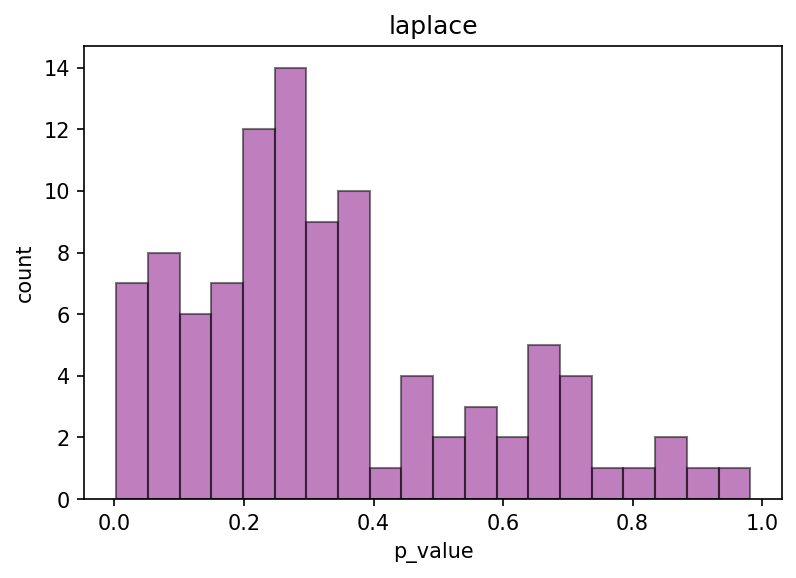

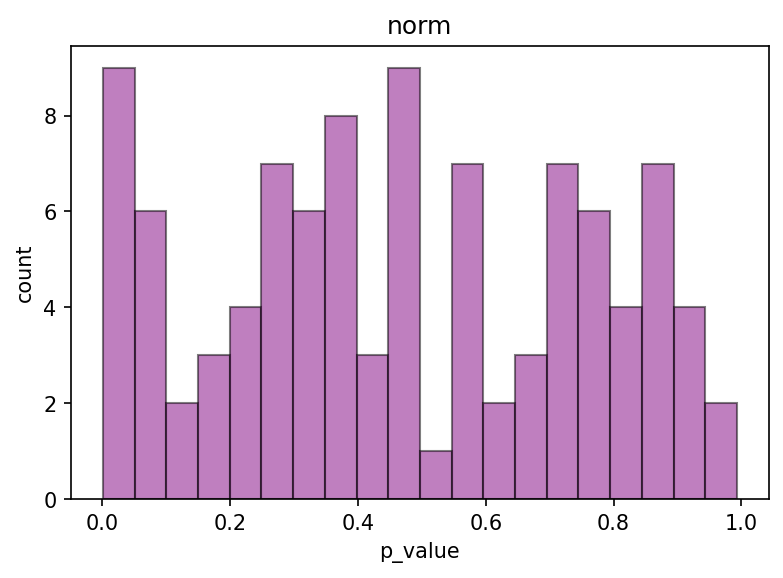

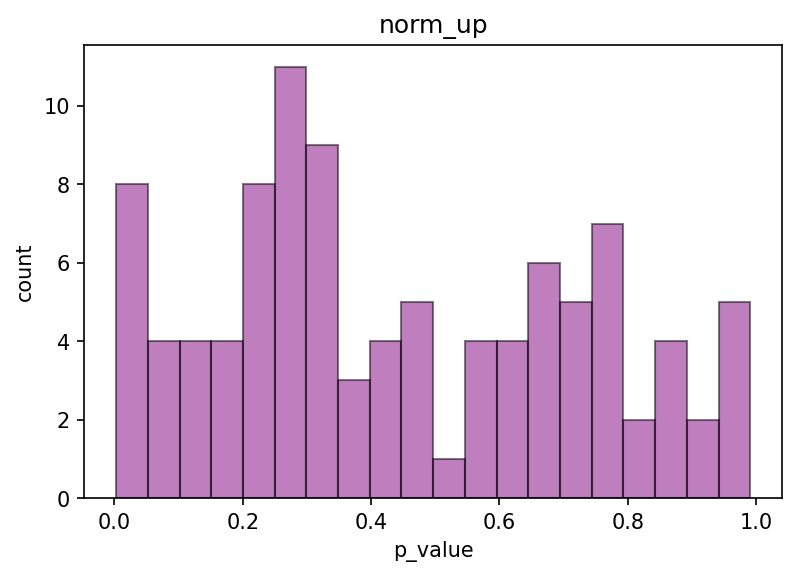

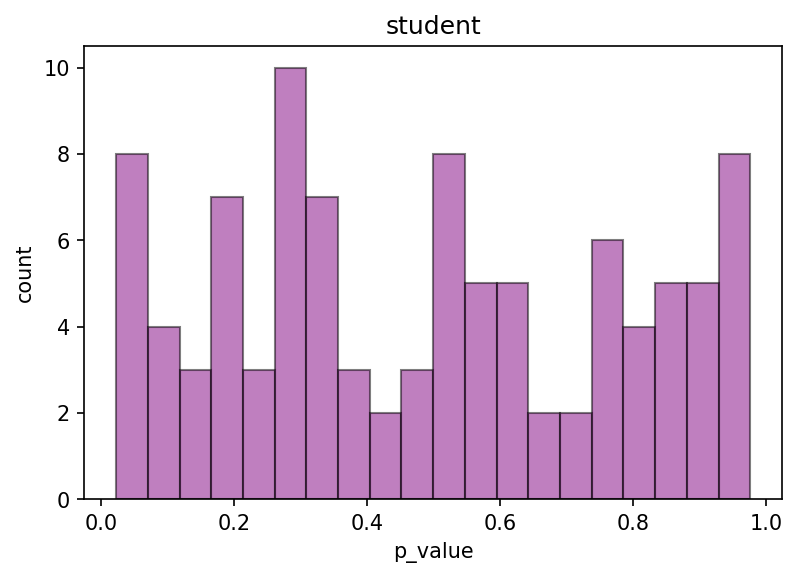

In [11]:
for distrib in ds: 
    plt.figure(dpi=150)
    plt.hist(p_values[distrib][100], bins=20, alpha=0.5, color='purple', edgecolor='black',
         linestyle='-');
    plt.ylabel('count')
    plt.xlabel('p_value')
    plt.title(distrib)

### 4) Критерий Андерсона-Дарлинга

In [12]:
f = open('ADQuantiles.txt', 'r')
s = f.readlines()
x = ([s[i].split() for i in range(len(s))])
x.remove(x[0])
x = list(map(lambda st: tuple([float(st[0]), float(st[1])]), x))

# def get_pvalue(statistic, x): 
#     p = list(map(lambda tup: (tup[0], abs(tup[1] - statistic)), x))
#     alpha = min(p, key=lambda x: x[1])[0]
#     return (1 - alpha)

p_values = {'laplace': {25:[], 50:[], 100:[], 1000:[]},
              'norm':{25:[], 50:[], 100:[], 1000: []},
              'norm_up':{25:[], 50:[], 100:[], 1000: []}, 
              'student':{25:[], 50:[], 100:[], 1000:[]}}

arr = []
for j in range(1000): 
    sample = np.random.normal(0,1, 1000)
    arr.append(anderson(sample, dist='norm').statistic)
arr.sort()    

def get_pvalue_update(sample, arr): 
    statistic = anderson(sample, dist='norm').statistic
    arr_1 = arr + [statistic]
    arr_1.sort()
    index = arr_1.index(statistic)
    return 1 - (index + 1) / len(arr)
    
for distribution in ds: 
    for size in sizes:
        for i in range(N): 
            sample_obs = selections[distribution][size][i]
            p_value = get_pvalue_update(sample_obs, arr)
            p_values[distribution][size].append(p_value)
            
f.close()

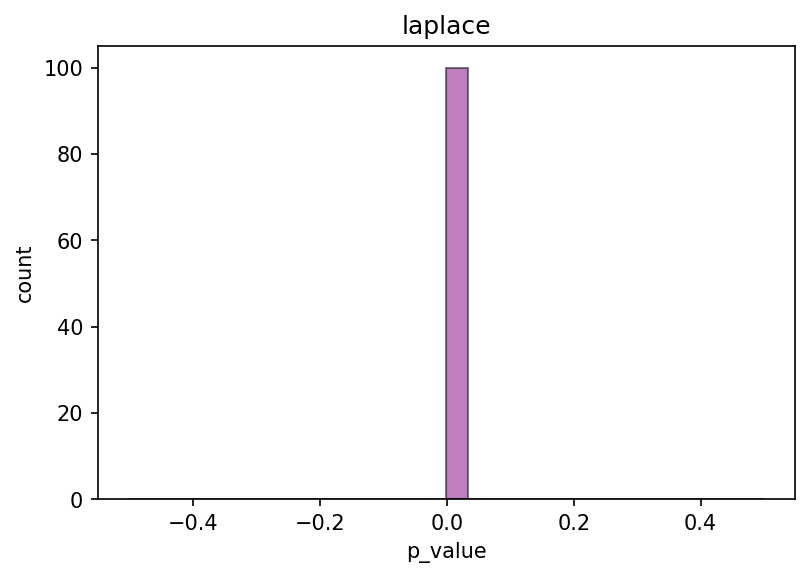

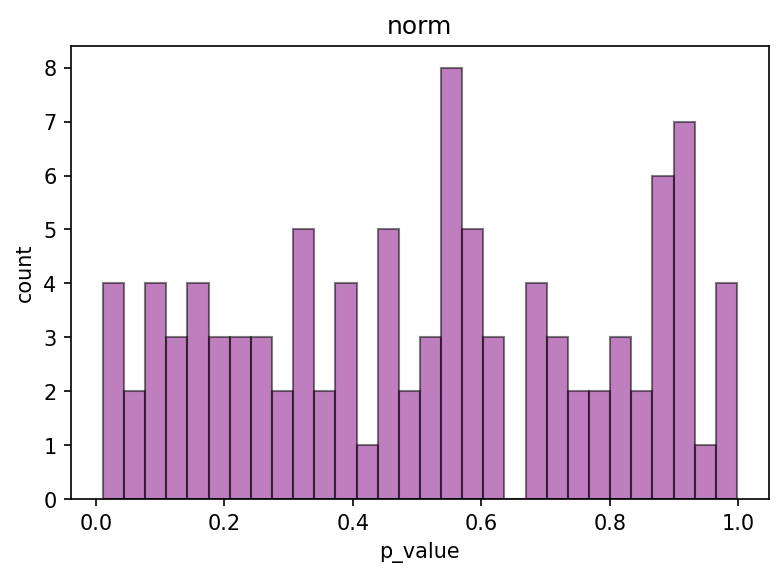

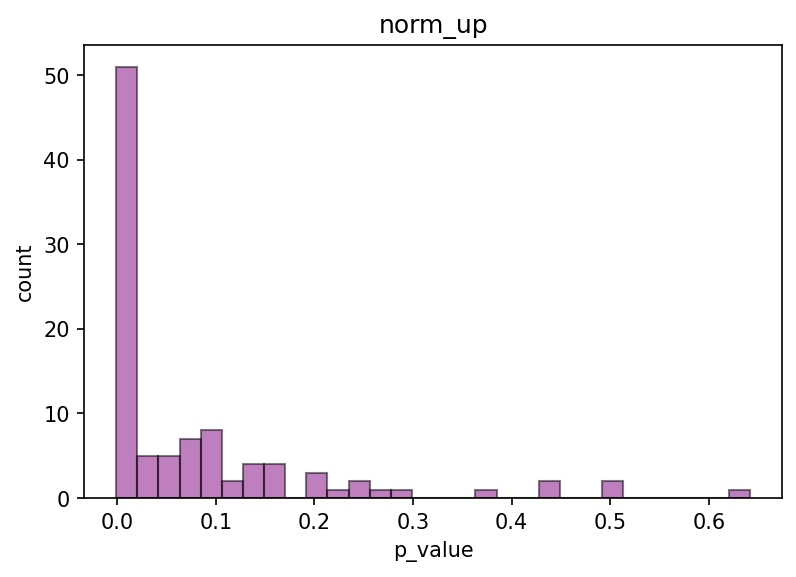

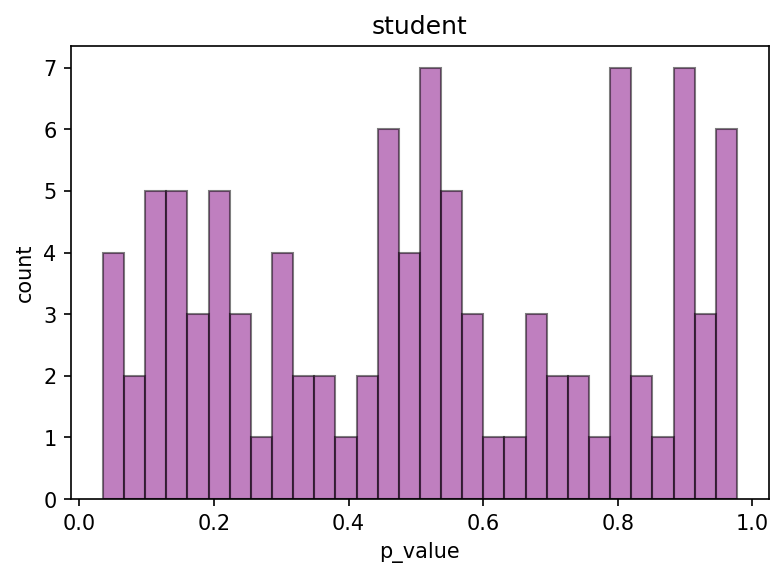

In [13]:
for distrib in ds: 
    plt.figure(dpi=150)
    plt.hist(p_values[distrib][1000], bins=30, alpha=0.5, color='purple', edgecolor='black',
         linestyle='-');
    plt.ylabel('count')
    plt.xlabel('p_value')
    plt.title(distrib)

# Т3

**Проверить нормальность выборки размеров 20, 50, 100 из**

* б) exp(1)
* г) хи-квадрат 1

**с помощью критериев Харке-Бера, Шапиро, Д’Агостино.**

Создание выборок

In [14]:
ds = ['exp', 'chisquare']
samples = {'exp':{25:[], 50:[], 100:[]}, 
           'chisquare':{25:[], 50:[], 100:[]}} 

for size in sizes: 
    samples['exp'][size] = np.random.exponential(scale=1.0, size=size)
    samples['chisquare'][size] = np.random.chisquare(1, size=size)

Критерий Харке-Бера

In [15]:
for dist in ds: 
    for size in sizes: 
        p_val = st.jarque_bera(samples[dist][size]).pvalue
        if p_val < 0.05:
            string = 'H0 отклонена, распределение не нормальное'
        else: 
            string = 'Не можем отврегнуть H0'
            
        print(f'Distribution: {dist} \n sample_size: {size} \n p_value: {p_val} \n {string}')
        print('_'*50)

Distribution: exp 
 sample_size: 25 
 p_value: 0.1828307172163799 
 Не можем отврегнуть H0
__________________________________________________
Distribution: exp 
 sample_size: 50 
 p_value: 6.07809358399436e-11 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: exp 
 sample_size: 100 
 p_value: 4.339441350698081e-08 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: exp 
 sample_size: 1000 
 p_value: 0.0 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chisquare 
 sample_size: 25 
 p_value: 0.02775585672365488 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chisquare 
 sample_size: 50 
 p_value: 3.552713678800501e-15 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chisquare 
 sample_size: 100 


Критерий Шапиро

In [16]:
for dist in ds: 
    for size in sizes: 
        p_val = st.shapiro(samples[dist][size]).pvalue
        if p_val < 0.05:
            string = 'H0 отклонена, распределение не нормальное'
        else: 
            string = 'Не можем отврегнуть H0'
            
        print(f'Distribution: {dist} \n sample_size: {size} \n p_value: {p_val} \n {string}')
        print('_'*50)

Distribution: exp 
 sample_size: 25 
 p_value: 0.051932208240032196 
 Не можем отврегнуть H0
__________________________________________________
Distribution: exp 
 sample_size: 50 
 p_value: 2.698618573049316e-06 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: exp 
 sample_size: 100 
 p_value: 1.2696554918534275e-09 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: exp 
 sample_size: 1000 
 p_value: 1.4827112100029133e-31 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chisquare 
 sample_size: 25 
 p_value: 0.0002699982433114201 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chisquare 
 sample_size: 50 
 p_value: 1.1457598247943679e-06 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chis

Критерий Д'Агностино

In [17]:
for dist in ds: 
    for size in sizes: 
        p_val = st.normaltest(samples[dist][size]).pvalue
        if p_val < 0.05:
            string = 'H0 отклонена, распределение не нормальное'
        else: 
            string = 'Не можем отврегнуть H0'
            
        print(f'Distribution: {dist} \n sample_size: {size} \n p_value: {p_val} \n {string}')
        print('_'*50)

Distribution: exp 
 sample_size: 25 
 p_value: 0.07115675282434156 
 Не можем отврегнуть H0
__________________________________________________
Distribution: exp 
 sample_size: 50 
 p_value: 1.2859587664028806e-06 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: exp 
 sample_size: 100 
 p_value: 3.3111683742676603e-06 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: exp 
 sample_size: 1000 
 p_value: 5.900287230602191e-75 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chisquare 
 sample_size: 25 
 p_value: 0.012641260888541776 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chisquare 
 sample_size: 50 
 p_value: 1.4462313146421298e-07 
 H0 отклонена, распределение не нормальное
__________________________________________________
Distribution: chisqu

# П1
Закон Бенфорда в его житейской интерпретации утверждает, что если выбрать набор каких-то чисел из реальных данных, то распределение первых цифр этих чисел будет иметь вид 
$𝑙𝑜𝑔_{10}(1+\frac{1}{k}), 𝑘 = 1, ..., 9$ 

Проверить его 
* а) на списке стран по населению, 
* б) на числах Фиббоначчи 
* в) интересном вам наборе данных.

In [18]:
def make_hist_benfort(sample, title): 
    N = len(sample)
    obs_nu = [sample.count(i)  for i in range(1,10)]
    exp_nu = [math.log10(1 + 1/k) * N for k in range(1, 10)]
    
    numbers = list(range(1,10))
    
    p_value = chisquare(obs_nu, f_exp=exp_nu).pvalue
    
    plt.figure(figsize=(10,5), dpi=200)
    
    plt.hist(numbers, weights=exp_nu, alpha=0.5, color='g', edgecolor='red')
    plt.hist(numbers, weights=obs_nu, alpha = 0.3, color='b',edgecolor='black',
         linestyle='--')
    
    plt.ylabel('frequency')
    plt.xlabel('number')
    plt.title(f'{title}\np_value = {p_value}')
    plt.legend(['exp_frequencies', 'obs_frequencies'])
    plt.show()

**a) population** 

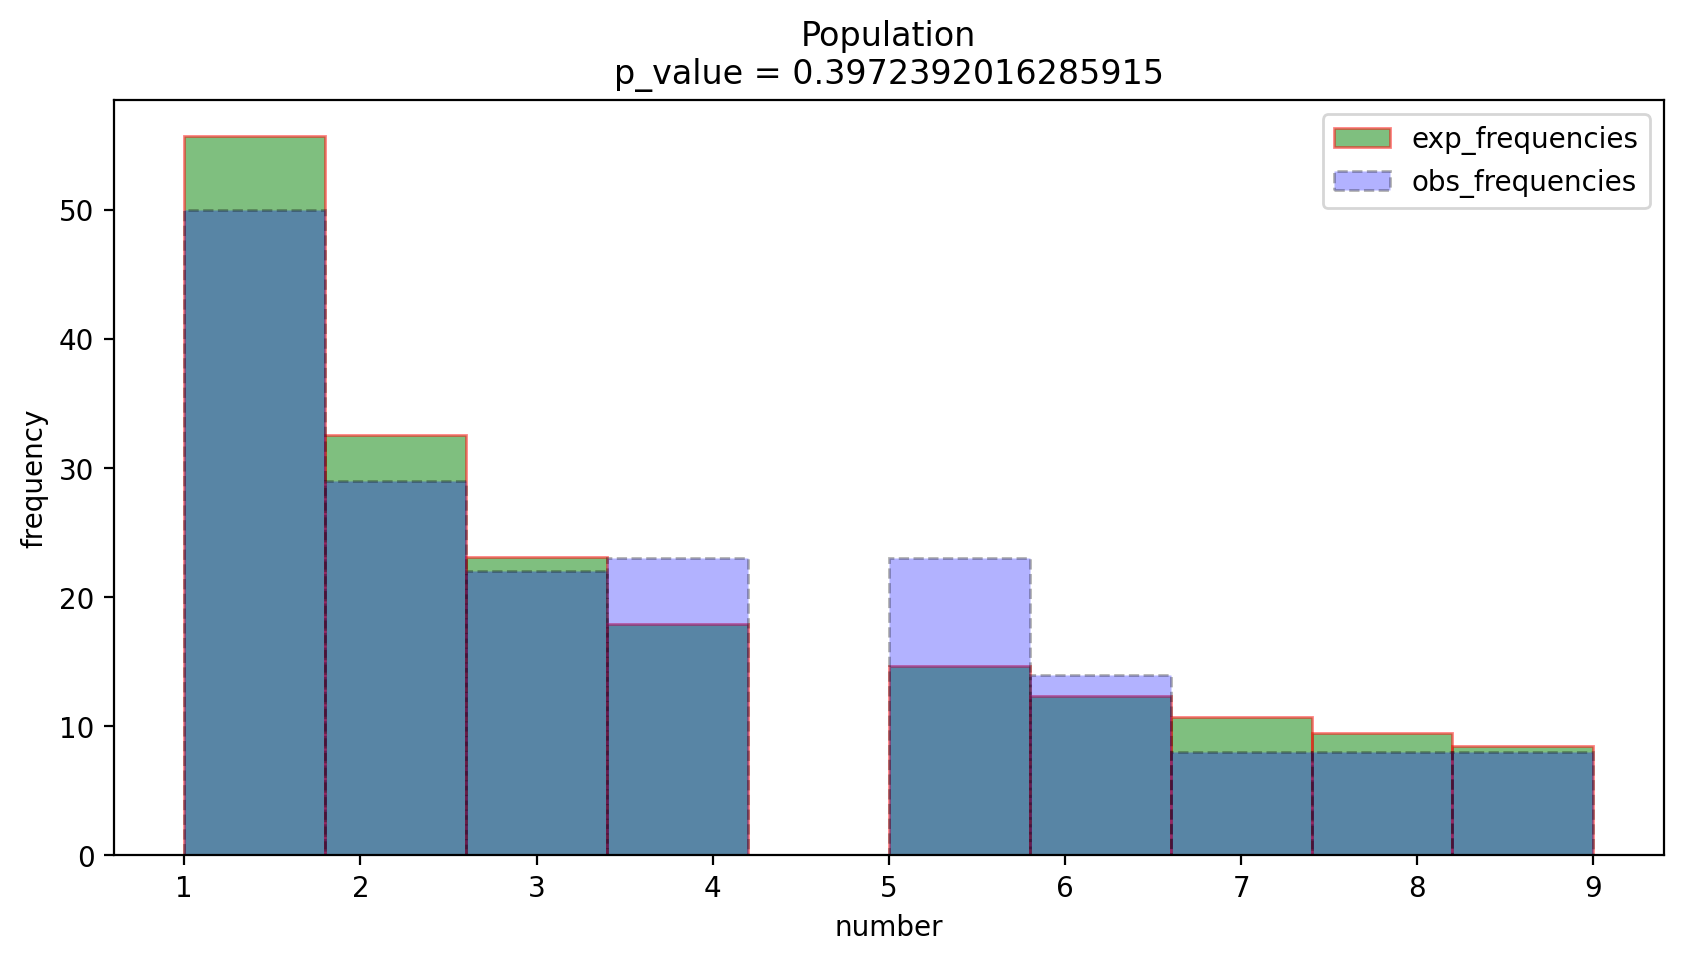

In [19]:
f = open('population.txt', 'r')
s = f.readlines()
population = []
for i in range(len(s)): 
    x = s[i].split(sep=';')
    for item in x: 
        if item.replace('\n', '').isnumeric(): 
            population.append(int(item[0]))
            
make_hist_benfort(population, 'Population')
f.close()

**b) fibonacci** 

In [20]:
def fib(n):
    if n == 1:
        return [1]
    elif n == 2:
        return [1, 2]
    else:
        lst = fib(n-1)
        lst.append(lst[-1] + lst[-2])
        return lst

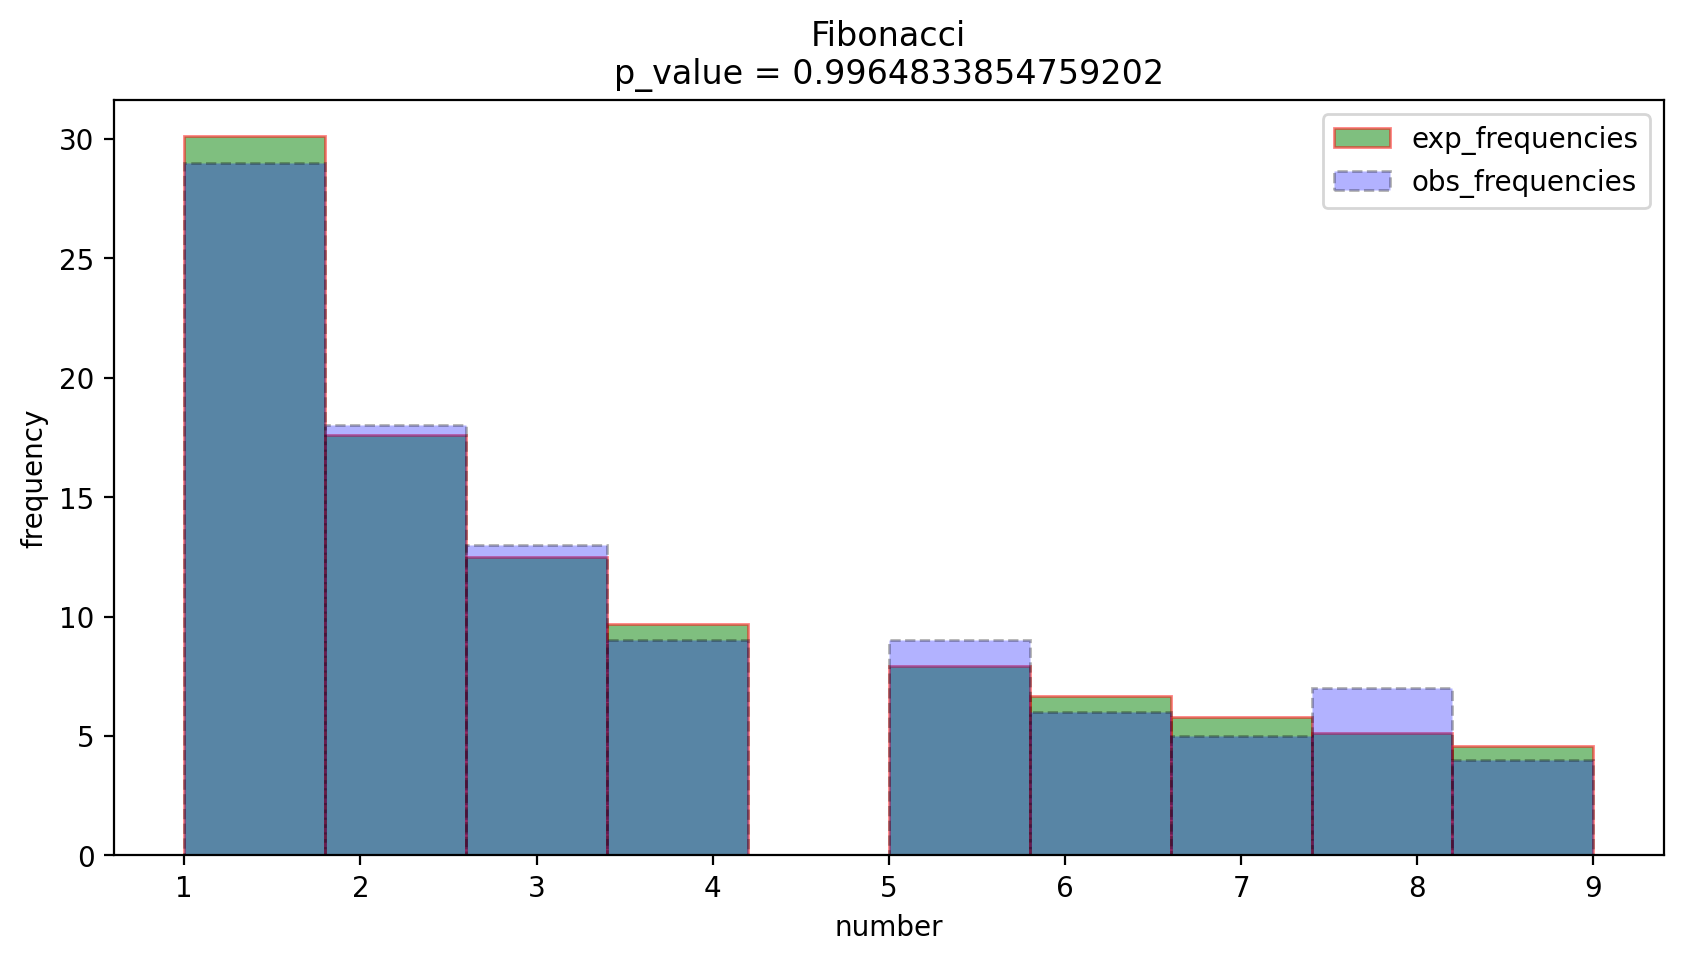

In [21]:
fib_series = fib(100)
fib_sample = list(map(lambda x: int(str(x)[0]),fib_series ))
make_hist_benfort(fib_sample, 'Fibonacci')

**c) kiama**

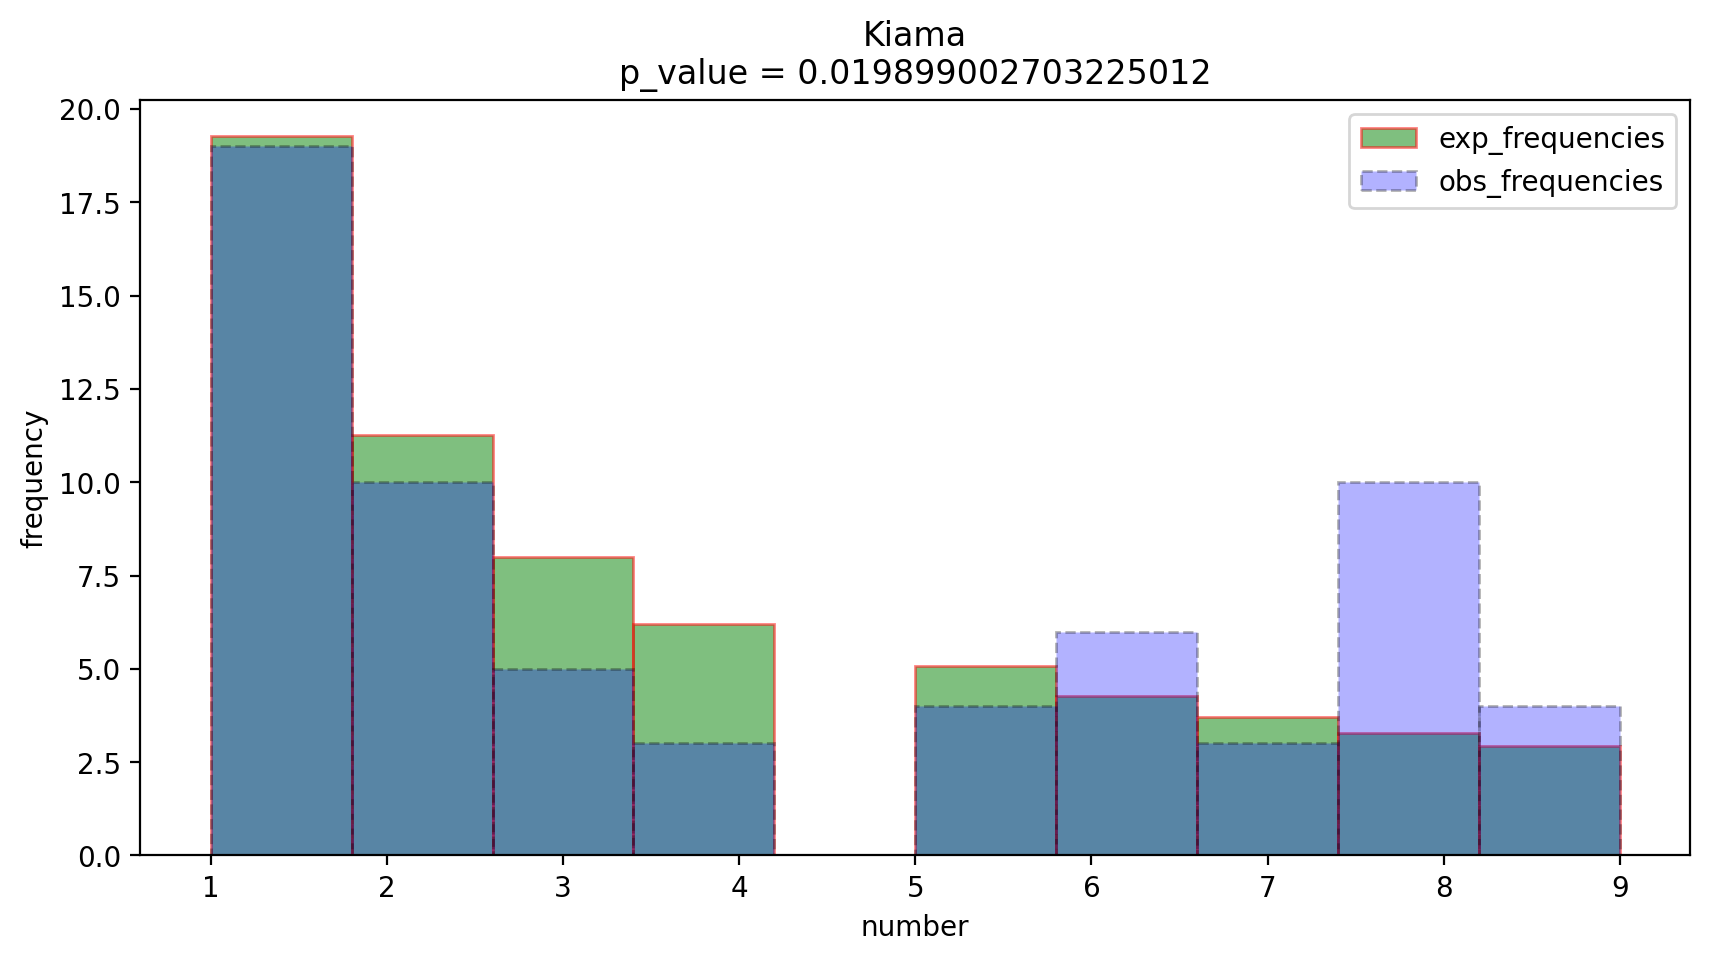

In [22]:
f = open('kiama.txt', 'r')
s = f.readlines()
s.remove(s[0])
kiama_sample = [int(item[0]) for item in s]
make_hist_benfort(kiama_sample, 'Kiama')
f.close()

# П2
Kiama Blowhole - это австралийская достопримечательность, представляющая собой отверстие в скале, через которое через некоторые промежутки вылетают фонтаны воды (в русском языки такие объекты называют ”дыхалом”). 

В файле kiama.txt приведены промежутки (в секундах) между такими извержениями, зафиксированные за некоторый промежуток изучения. Можем ли мы утверждать, что извержения образуют пуассоновский процесс (то есть происходят через независимые экспоненциальные времена с одинаковым параметром). Если да, то оцените его параметр с помощью ОМП.


In [23]:
f = open('kiama.txt', 'r')
s = f.readlines()
s.remove(s[0])
kiama = [int(item) for item in s]
f.close()

In [24]:
print(kiama)

[83, 51, 87, 60, 28, 95, 8, 27, 15, 10, 18, 16, 29, 54, 91, 8, 17, 55, 10, 35, 47, 77, 36, 17, 21, 36, 18, 40, 10, 7, 34, 27, 28, 56, 8, 25, 68, 146, 89, 18, 73, 69, 9, 37, 10, 82, 29, 8, 60, 61, 61, 18, 169, 25, 8, 26, 11, 83, 11, 42, 17, 14, 9, 12]


Предварительный просмотр

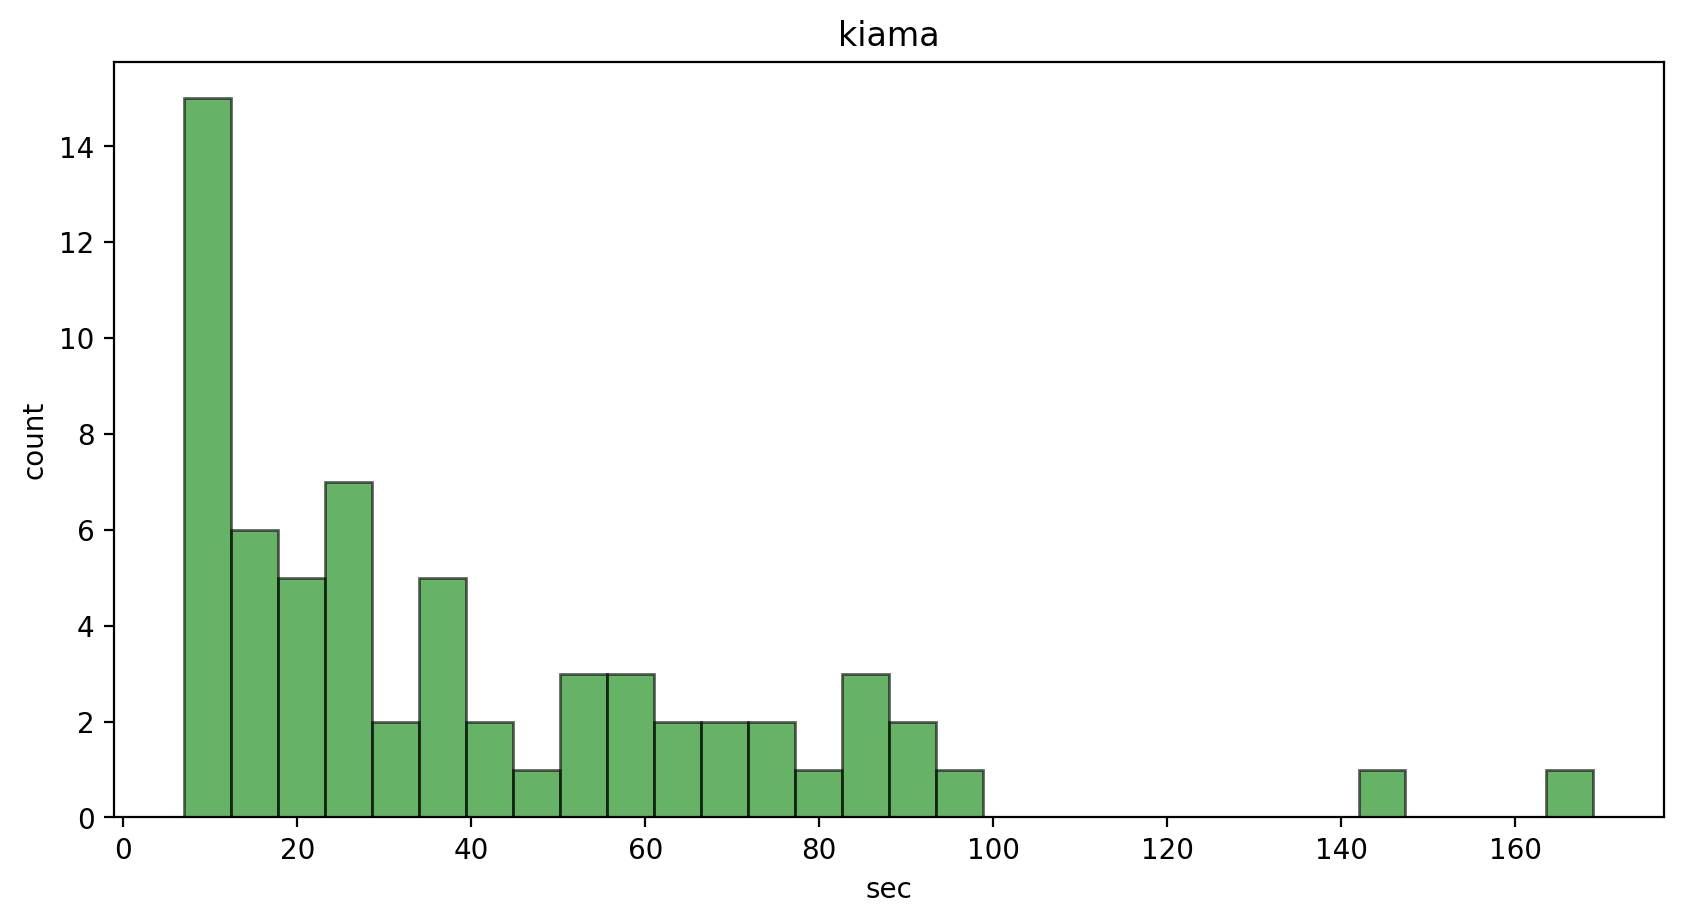

In [25]:
plt.figure(figsize=(10,5), dpi=200)
plt.hist(kiama,bins=30, alpha=0.6,color='green', edgecolor='black')
plt.xlabel('sec')
plt.ylabel('count')
plt.title('kiama')
plt.show()

In [26]:
def get_lambda(sample): 
    lamb = Symbol('lambda', positive=True)
    probs = [E**(-lamb)*lamb**(x) / math.factorial(x) for x in sample]
    ln_probs = [expand_log(log(item)) for item in probs]
    omp = sum(ln_probs)
    d_omp = diff(omp, lamb)
    answer = solve(Eq(d_omp), lamb)[0]
    return float(answer.n())

**Q-Q plot**

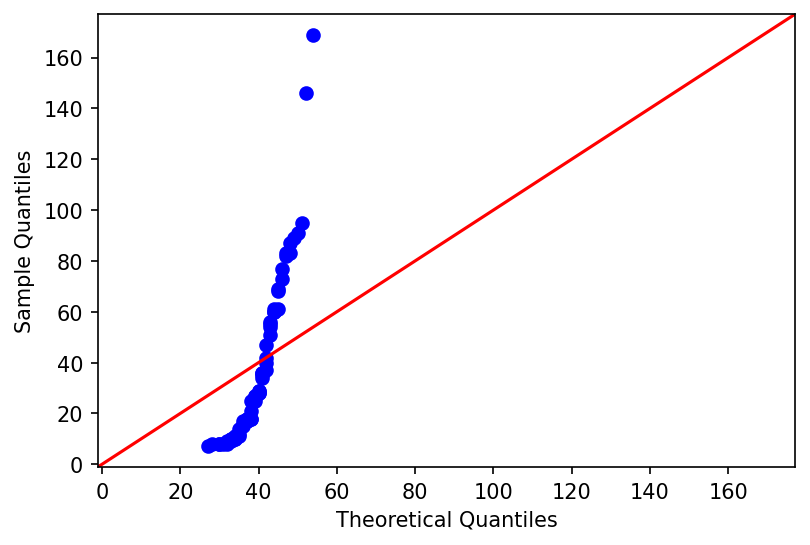

In [27]:
lamb = get_lambda(kiama)
fig = sm.qqplot(np.array(kiama), dist= st.poisson(lamb), line='45');
fig.size=(10,5)
fig.dpi=150

In [28]:
lamb = get_lambda(kiama)
lamb

39.828125

**Тест Колмогорова**

In [29]:
res = kstest(kiama, 'poisson', args=(lamb,0)).pvalue
print("p_value:", res)
if res < 0.05: 
    print("Отвергаем H0: распределение не Пуассоновское")
else: 
    print("Не можем отвергнуть H0")

p_value: 2.1348881720643348e-15
Отвергаем H0: распределение не Пуассоновское
